In [1]:
import os
import SimpleITK as sitk
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split

In [2]:
# Getting data name
path_data = os.path.join('/nas', 'breast')
path_abimg = os.path.join(path_data, 'image', 'abnormal')
path_nrimg = os.path.join(path_data, 'image', 'normal')

abnameList = sorted([name.split('.')[0] for name in os.listdir(path_abimg) if name.endswith('.dcm')])
nrnameList = sorted([name.split('.')[0] for name in os.listdir(path_nrimg) if name.endswith('.dcm')])

print(f'Abnormal: {len(abnameList)}')
print(f'Normal: {len(nrnameList)}')

Abnormal: 250
Normal: 250


Sample name: AN_151


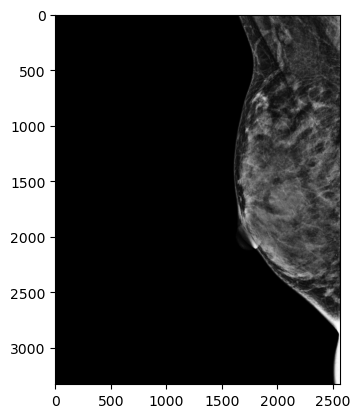

In [3]:
# Data preprocessing in a sample data

abname = abnameList[150]
print(f'Sample name: {abname}')

## Checking a original sample image
img = sitk.ReadImage(os.path.join(path_abimg, f'{abname}.dcm'))
img = sitk.GetArrayFromImage(img)[0]

plt.imshow(img, cmap='gray')

In [10]:
## CLAHE 전처리 적용

clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (18,18))
img_clahe = clahe.apply(img)


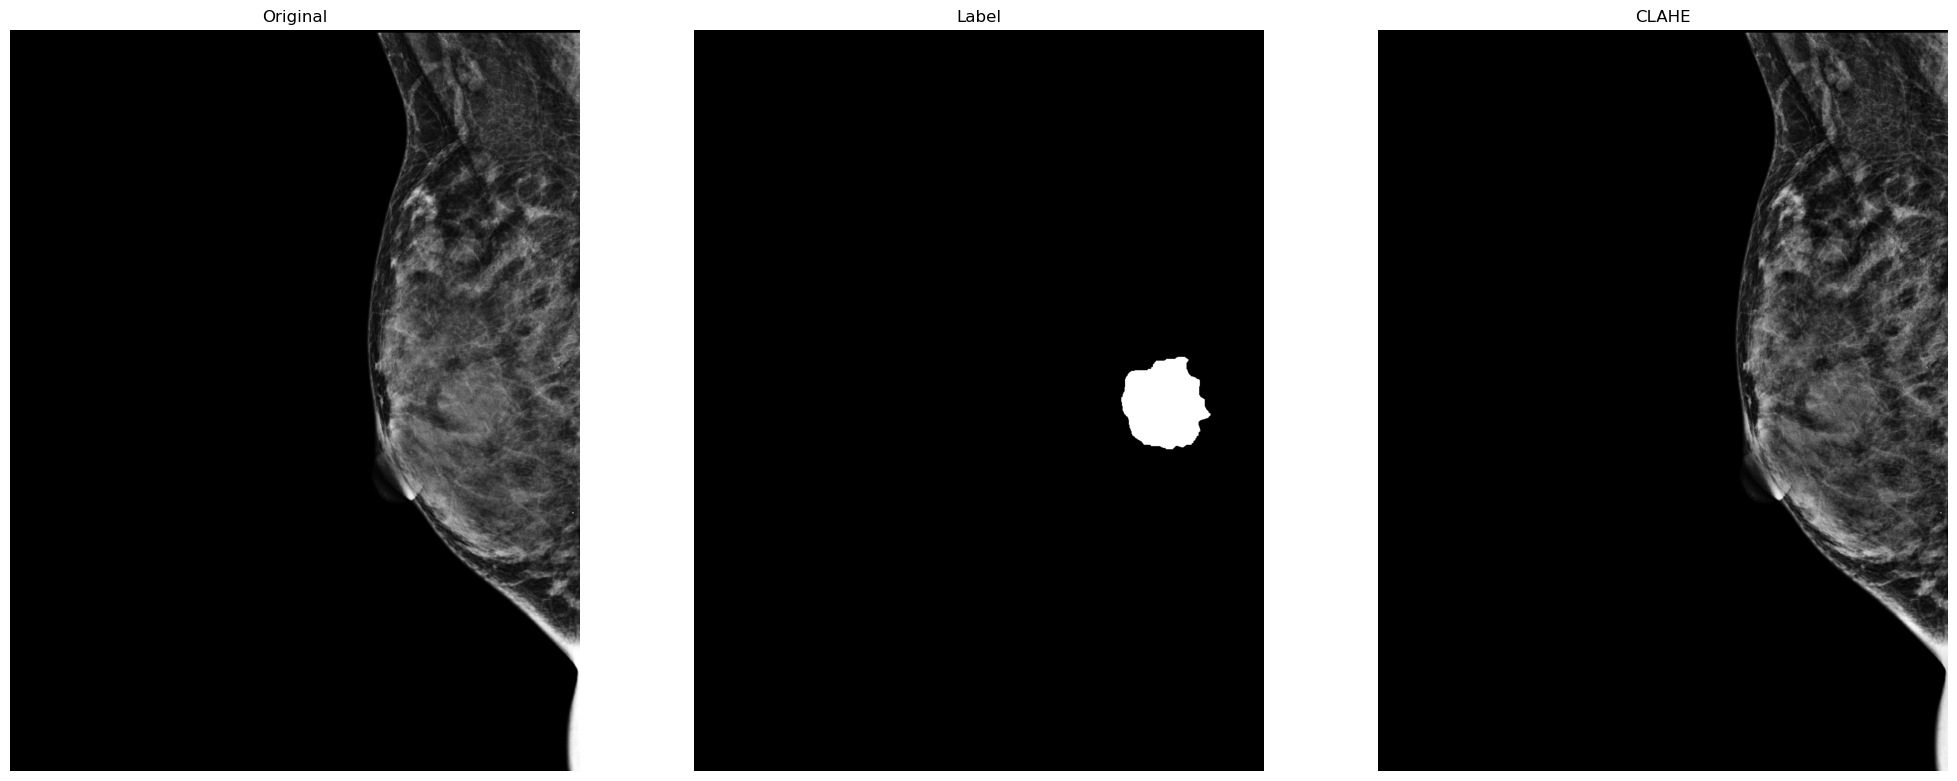

In [11]:
ablab = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join('/nas/breast/label/nii', f'{abname}.nii')))[0]
plt.figure(figsize=(25,25))
plt.subplot(1,3,1)
plt.title(f'Original')
plt.imshow(img,cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title(f'Label')
plt.imshow(ablab,cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title(f'CLAHE')
plt.imshow(img_clahe,cmap='gray')
plt.axis('off')
plt.show()

In [12]:
# Saving grayscale images as numpy format

n_class = 2         # Normal: 0 | Abnormal: 1 
imageSize = 512     # 임의 설정값. 반드시 width 및 height가 같을 필요 없으며 특정값의 배수로 설정해주면 됨. 단, 네트워크의 크기에 맞게 조절해야함.

os.makedirs(os.path.join(os.path.abspath('.'), 'npy'), exist_ok=True)           # Setting saving path

## Making empty array for stacking all data
array_img = np.ndarray((0,imageSize,imageSize), np.float32)
array_lab = np.ndarray((0,n_class))

## Stacking abnormal data
for name in abnameList:

    # loading image from dicom format
    img = sitk.ReadImage(os.path.join(path_abimg, f'{name}.dcm'))
    img = sitk.GetArrayFromImage(img)[0]
    img = clahe.apply(img)
    img = img/(img.max()-img.min())     # min-max normalization

    img = cv2.resize(img, (imageSize, imageSize), interpolation=cv2.INTER_AREA)
    img = np.expand_dims(img, axis=0)   # expanding image dimension

    # Making label data
    lab = np.asarray([0, 1])    # abnormal label: 1
    lab = np.expand_dims(lab, axis=0)

    array_img = np.concatenate([array_img, img], axis=0)    # Stacking data
    array_lab = np.concatenate([array_lab, lab], axis=0)

In [13]:
clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (18,18))

def getting_img(path_img, imageSize):
    img = sitk.ReadImage(path_img)
    img = sitk.GetArrayFromImage(img)[0]
    
    img = clahe.apply(img)
    img = img/(img.max()-img.min())

    img = cv2.resize(img, (imageSize, imageSize), interpolation=cv2.INTER_AREA)
    img = np.expand_dims(img, axis=0)
    
    return img

In [14]:
## Stacking normal data

for name in nrnameList:
    img = getting_img(os.path.join(path_nrimg, f'{name}.dcm'), imageSize)

    lab = np.asarray([1, 0])    # normal label: 0
    lab = np.expand_dims(lab, axis=0)
    
    array_img = np.concatenate([array_img, img], axis=0)
    array_lab = np.concatenate([array_lab, lab], axis=0)

# Check data shape
array_img = np.expand_dims(array_img, axis=-1)      # input shape에 맞춰줌. (n_images, image_height, image_width, channel)
print(f'Image shape: {array_img.shape} | Label shape: {array_lab.shape}')

Image shape: (500, 512, 512, 1) | Label shape: (500, 2)


In [15]:
## Saving data for numpy format
train_x, test_x, train_y, test_y= train_test_split(array_img, array_lab, test_size=0.1, random_state=4, stratify= array_lab)

np.save(os.path.join(os.path.abspath('.'), 'npy', 'train_img.npy'), train_x)
np.save(os.path.join(os.path.abspath('.'), 'npy', 'test_img.npy'), test_x)
np.save(os.path.join(os.path.abspath('.'), 'npy', 'train_lab.npy'), train_y)
np.save(os.path.join(os.path.abspath('.'), 'npy', 'test_lab.npy'), test_y)
